In [1]:
# Lab 6 - Association Rule Mining with Apriori and FP-Growth

In [2]:
# 🧾 Metadata
# Name: Avinna Bhattarai
# Course: MSCS 634
# Assignment: Lab 6

In [3]:
# Step 1: Imports & Data Load
# We import all necessary libraries for data handling, visualization, and mining.
# These are foundational tools for performing frequent pattern and association rule mining.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [4]:
# Step 2: Load Events Data
# Load the Retail Rocket events data locally. This CSV includes user interactions like views and purchases.
# We start with an overview to ensure we loaded the file correctly and understand its structure.
file_path = 'archive/events.csv'  

df = pd.read_csv(file_path)
print("Columns in the dataset:", df.columns.tolist())
df.head()

Columns in the dataset: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']


,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
# Step 3: Data Cleaning
# Clean column names to ensure consistent lowercase formatting.
df.columns = df.columns.str.strip().str.lower()
print("Cleaned columns:", df.columns.tolist())

# Try to inspect column names to find a substitute if 'event_type' is missing
if not 'event_type' in df.columns:
    print("Warning: 'event_type' column not found. Available columns:", df.columns.tolist())
else:
    # Filter the dataset to include only 'view' and 'purchase' events for transaction relevance.
    df = df[df['event_type'].isin(['view', 'purchase'])]

# Convert itemid to string and keep only the necessary columns for transaction creation
if 'itemid' in df.columns and 'visitorid' in df.columns:
    df['itemid'] = df['itemid'].astype(str)
    df_clean = df[['visitorid', 'itemid']].drop_duplicates()
else:
    raise ValueError("Required columns 'visitorid' and/or 'itemid' are missing from the dataset.")


Cleaned columns: ['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']


In [6]:
# Step 4: Transaction Formatting
# We group items by each visitor ID to prepare a list-style transaction format.
# This is required for Apriori and FP-Growth input.
transactions = df_clean.groupby('visitorid')['itemid'].apply(list).reset_index()
transactions.head()

,visitorid,itemid
0,0,"[285930, 357564, 67045]"
1,1,[72028]
2,2,"[216305, 325215, 342816, 259884]"
3,3,[385090]
4,4,[177677]


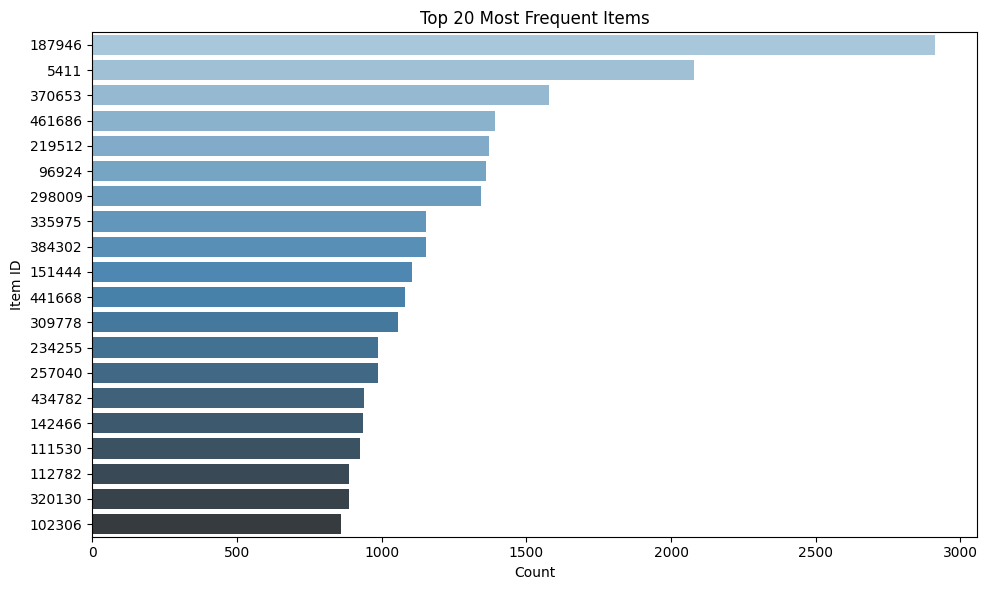

: 

In [ ]:
# Step 5: Visualize Most Frequent Items
# We count how often each item appears and plot the top 20.
# This provides insight into product popularity and helps verify data consistency.
item_counts = Counter([item for sublist in transactions['itemid'] for item in sublist])
top_items = pd.DataFrame(item_counts.items(), columns=['item', 'count']).sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(data=top_items, x='count', y='item', hue='item', palette='Blues_d', legend=False)
plt.title("Top 20 Most Frequent Items")
plt.xlabel("Count")
plt.ylabel("Item ID")
plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Apriori Algorithm
# Apply Apriori to identify frequent itemsets based on minimum support.
# This helps uncover common product combinations in user behavior.
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

te = TransactionEncoder()
te_data = te.fit(transactions['itemid']).transform(transactions['itemid'])
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

frequent_itemsets_apriori = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets_apriori.sort_values(by='support', ascending=False).head()


In [ ]:
# Visualize Apriori Itemsets
# We display the top 10 most frequent itemsets found by Apriori.
# This gives a quick understanding of strong item combinations.
top_apriori = frequent_itemsets_apriori.nlargest(10, 'support')
sns.barplot(data=top_apriori, x='support', y=top_apriori['itemsets'].astype(str))
plt.title('Top 10 Frequent Itemsets (Apriori)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Step 7: FP-Growth Algorithm
# Run FP-Growth with the same support threshold.
# This is generally faster than Apriori and avoids candidate generation.
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets_fpgrowth.sort_values(by='support', ascending=False).head()

In [ ]:
# Visualize FP-Growth Itemsets
top_fpgrowth = frequent_itemsets_fpgrowth.nlargest(10, 'support')
sns.barplot(data=top_fpgrowth, x='support', y=top_fpgrowth['itemsets'].astype(str))
plt.title('Top 10 Frequent Itemsets (FP-Growth)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step 8: Association Rules
# Generate association rules from both algorithms.
# We evaluate rules using metrics: confidence, lift, and support.
rules_apriori = association_rules(frequent_itemsets_apriori, metric='confidence', min_threshold=0.5)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric='confidence', min_threshold=0.5)

# Display a sample of the rules
rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

# Visualize Confidence vs Lift (Apriori)
# Helps identify strong, high-confidence rules
sns.scatterplot(data=rules_apriori, x='confidence', y='lift')
plt.title('Apriori: Confidence vs Lift')
plt.show()

In [ ]:
# Visualize Confidence vs Lift (FP-Growth)
sns.scatterplot(data=rules_fpgrowth, x='confidence', y='lift')
plt.title('FP-Growth: Confidence vs Lift')
plt.show()

In [ ]:
# Step 9: Comparison & Discussion
# Summary of performance and insights
print("\n--- Comparison ---")
print(f"Apriori: {len(frequent_itemsets_apriori)} itemsets, {len(rules_apriori)} rules")
print(f"FP-Growth: {len(frequent_itemsets_fpgrowth)} itemsets, {len(rules_fpgrowth)} rules")

print("\nFP-Growth is generally faster because it avoids candidate generation.")
print("Apriori is more intuitive but computationally expensive on large datasets.")
